# Modelling the Fano 2024, Italy dengue outbreaks: The effects of control strategies and environmental extremes
**Author:** Sandeep Tegar<sup>1, 2</sup> and Dominic P. Brass<sup>1</sup> 

**Contact:** santeg@ceh.ac.uk  
**Date:** 2025-03-17   
**Affiliation:**
1. UK Centre for Ecology & Hydrology, Benson Lane, Wallingford, Oxfordshire, UK
2. School of Mathematics and Statistics, College of Science and Engineering, University of Glasgow, Glasgow, UK   


## Overview  
This notebook contains the code used in our study. It performs model simulation using function `dengue()`. Finally, obtain the *Ae. albopictus* and its oviposition activity.  

## Requirements  
- Julia 1.10.0+  
- Required libraries: `Plots`, `DelayDiffEq`, `Dierckx`, `CSV`, `Interpolations`, `QuadGK`, `Statistics`, `Dates`, `DataFrames`, `RecurssiveArrayTools`, `TimeSeries` 
- Data files: `AMgam.csv`, `Car_Tol_1.csv`, `Fin_LSurv.csv`, `LDgam.csv`, `WL_re.csv`
- Function files: AlbopictusFun.jl
## Extra requirement
ERA5 climate data file "43.82_13.026.csv" (format: latitude_longitude.csv) coulmns: time, logitude, latitude, t2m, tp, evaow, where 't2m', 'tp', and 'evaow' stand for  "2m_temperature", "total_precipitation", and "evaporation_from_open_water_surfaces_excluding_oceans", respectively. Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

## Usage  
Save all the required files in the working directory and simply run the cells in order to reproduce the results.  

In [1]:
# load the required packages 
using Plots, DelayDiffEq, Dierckx, CSV, Interpolations, QuadGK, Statistics, Dates, DataFrames, RecursiveArrayTools, TimeSeries

In [ ]:
# call the dengue() frunction from AlbopictusFun file
include("AlbopictusFun.jl")

dengue (generic function with 1 method)

In [3]:

# Simulate model for seeding date with the lowest RMSE
start_date_str = "18.11.2021"
seed_date_str = string(Dates.format(Date(2024, 07, 17), "dd.mm.yyyy"))
#seed_date_str = "29.07.2024"
sol, tauE, gt, q_store, egg_total_inst, tauL, tauP = dengue(43.82, 13.026, start_date_str, "18.11.2024", seed_date_str);

In [4]:
# Create the time array from the simulation output
time = sol.t
out = hcat(sol.u...)

206×1097 Matrix{Float64}:
    1.0           1.27295       1.41156    …    117.935        109.285
  150.0         148.507       147.03          13344.0        13211.2
    1.0           0.563954      0.312152          0.044237       0.0298633
  100.0          84.1187       69.5403           57.8914        52.5526
    4.67774       4.67794       4.71261           4.90092        4.91951
    0.0686526     0.0686362     0.066195   …      0.0556922      0.0545791
   13.5109       13.5071       13.4979           15.9867        15.354
    0.0938442     0.0939159     0.0924423         0.0722049      0.0823397
   17.2502       17.2502       17.2502           13.4429        13.6736
    0.0407573     0.0407573     0.0407573         0.108709       0.101734
    ⋮                                      ⋱      ⋮          
    0.870658      0.870651      0.869292          0.845652       0.841842
    0.870658      0.870651      0.869292          0.845652       0.841842
    0.870658      0.870651      0.869

In [5]:
# numberings
nWing = 64
numb_E_1   = 1 
numb_E_D   = 2
numb_E_Q   = 3
numb_L_1   = 4
numb_t_E   = 5
numb_P_E   = 6
numb_t_L   = 7
numb_P_L   = 8
numb_t_P   = 9
numb_P_P   = 10
numb_A_1   = 11
numb_A_2       = nWing + 10
numb_I_1       = nWing + 11
numb_I_2       = 2* nWing + 10
numb_EIP       = 2 * nWing + 11
numb_P_EIP_1   = 2 * nWing + 12
numb_P_EIP_2   = 3 * nWing + 11
numb_H_S       = 3 * nWing + 12
numb_H_I       = 3 * nWing + 13
numb_H_R       = 3 * nWing + 14;

In [6]:
# total adults
adults = out[numb_A_1:numb_A_2, :]
sumA = sum(adults, dims=1)[1, :]

1097-element Vector{Float64}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   ⋮
 168.0703651589588
 162.46895684483954
 156.8149941598104
 149.38158348141178
 123.79105559121177
 107.25070620879322
  99.31746674719251
  86.50546200053545
  81.78109026474739

In [7]:
# oviposition activity
# total eggs
adults_AI = out[numb_A_1:numb_A_2, :]

tosum_E = (repeat(q_store, 1).*adults_AI)./transpose(gt)
eggs_in = sum(tosum_E, dims=1)[1, :]

eggs_daily_sp = Spline1D(time, eggs_in)
tauE_daily_sp = Spline1D(time, tauE)

sampling_period = 7

ovi_obs = repeat([0.0], length(time))
for i = 21:length(time)
    if tauE_daily_sp(i) < sampling_period
        ovi_obs[i] =   sum(eggs_daily_sp(1:i)) - sum(eggs_daily_sp(1:i - tauE_daily_sp(i)))
    else
        ovi_obs[i] =   sum(eggs_daily_sp(1:i)) - sum(eggs_daily_sp(1:Int(i - sampling_period)))
    end
end

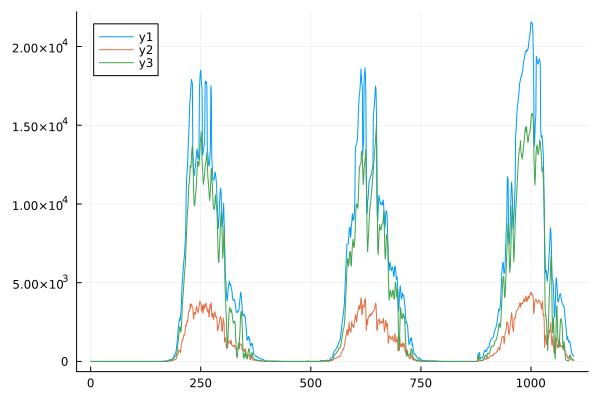

In [8]:
plot(ovi_obs)
plot!(eggs_in)
plot!(egg_total_inst)

In [9]:
# writing output time series
start_date = Date(start_date_str, "dd.mm.yyyy")
dates =  start_date .+ Day.(Int.(time))
egg_adult_data = hcat(sumA, egg_total_inst, eggs_in, ovi_obs)
ts = TimeArray(dates, egg_adult_data, ["total_adults", "egg_total_inst", "egg_daily", "egg_sampled"])

1097×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-11-18 to 2024-11-18
┌────────────┬──────────────┬────────────────┬───────────┬─────────────┐
│            │ total_adults │ egg_total_inst │ egg_daily │ egg_sampled │
├────────────┼──────────────┼────────────────┼───────────┼─────────────┤
│ 2021-11-18 │          0.0 │            2.0 │       0.0 │         0.0 │
│ 2021-11-19 │          0.0 │         1.8369 │       0.0 │         0.0 │
│ 2021-11-20 │          0.0 │        1.72371 │       0.0 │         0.0 │
│ 2021-11-21 │          0.0 │        1.60676 │       0.0 │         0.0 │
│ 2021-11-22 │          0.0 │        1.63101 │       0.0 │         0.0 │
│ 2021-11-23 │          0.0 │        1.64621 │       0.0 │         0.0 │
│ 2021-11-24 │          0.0 │        1.63652 │       0.0 │         0.0 │
│ 2021-11-25 │          0.0 │        1.62042 │       0.0 │         0.0 │
│     ⋮      │      ⋮       │       ⋮        │     ⋮     │      ⋮      │
│ 2024-11-12 │      156.815 │        283.078 │ 

In [ ]:
# uncommnet to save output to csv
#df = DataFrame(ts)
#CSV.write("fano_simulation/fano_sim_C/egg_adult_C.csv", df)

"fano_simulation/fano_sim_C/egg_adult_C.csv"

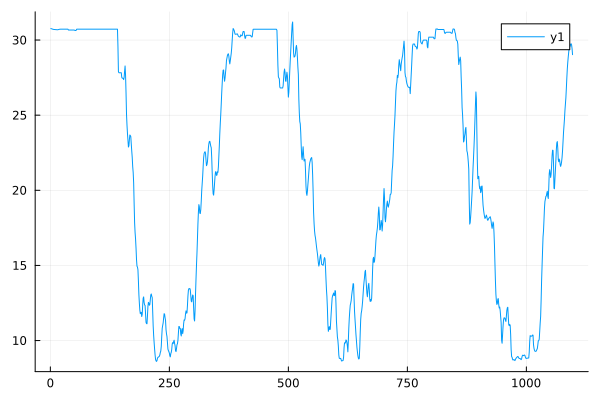

In [ ]:
# Plot oviposition activity
plot(tauL.+tauP)

In [14]:
# writing output time series for Larval to Adult development time
start_date = Date(start_date_str, "dd.mm.yyyy")
dates =  start_date .+ Day.(Int.(time))
tauLP = tauL .+ tauP
dt_data = hcat(tauL, tauP, tauLP)
ts = TimeArray(dates, dt_data, ["dt_L", "dt_P", "dt_LP"])

1097×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-11-18 to 2024-11-18
┌────────────┬─────────┬─────────┬─────────┐
│            │ dt_L    │ dt_P    │ dt_LP   │
├────────────┼─────────┼─────────┼─────────┤
│ 2021-11-18 │ 13.5109 │ 17.2502 │ 30.7611 │
│ 2021-11-19 │ 13.5071 │ 17.2502 │ 30.7573 │
│ 2021-11-20 │ 13.4979 │ 17.2502 │ 30.7481 │
│ 2021-11-21 │ 13.4857 │ 17.2502 │ 30.7359 │
│ 2021-11-22 │ 13.4736 │ 17.2502 │ 30.7239 │
│ 2021-11-23 │ 13.4639 │ 17.2502 │ 30.7141 │
│ 2021-11-24 │ 13.4572 │ 17.2502 │ 30.7074 │
│ 2021-11-25 │ 13.4541 │ 17.2502 │ 30.7044 │
│     ⋮      │    ⋮    │    ⋮    │    ⋮    │
│ 2024-11-12 │ 18.7205 │ 10.8178 │ 29.5383 │
│ 2024-11-13 │ 18.2686 │ 11.3388 │ 29.6074 │
│ 2024-11-14 │ 17.8741 │ 11.8468 │  29.721 │
│ 2024-11-15 │ 17.3681 │ 12.3893 │ 29.7574 │
│ 2024-11-16 │  16.724 │ 12.9506 │ 29.6746 │
│ 2024-11-17 │ 15.9867 │ 13.4429 │ 29.4296 │
│ 2024-11-18 │  15.354 │ 13.6736 │ 29.0276 │
└────────────┴─────────┴─────────┴─────────┘
                       

In [ ]:
# uncomment to save output to csv
#df = DataFrame(ts)
#CSV.write("fano_simulation/fano_sim_A/dt_A.csv", df)

"fano_simulation/fano_sim_A/dt_A.csv"